# Minimal Workflow — Week 1 + Simple Loading

This notebook contains only:
- Week 1 environment/dataset checks and key columns notes
- A simple, explicit CSV loading section (df1..df8) and a concat into df


In [1]:
# Week 1 — Environment & Dataset Access
from pathlib import Path
import re
import pandas as pd
import sys, shutil, platform

print({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "git": shutil.which("git") is not None,
    "jupyter": True,
})

DATA_DIR = Path.cwd()
RAW_PATTERN = re.compile(r"^CRMLSSold\d{6}.*\.csv$", re.I)
raw_files = sorted([p for p in DATA_DIR.iterdir() if p.is_file() and RAW_PATTERN.match(p.name)])
print(f"Found {len(raw_files)} CSV files")
raw_files[:5]


{'python': '3.12.4', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'git': True, 'jupyter': True}
Found 8 CSV files


[PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202501_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202502_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202503_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202504_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202505_filled.csv')]

In [3]:
# Week 1 — Key Columns Notes (auto-match)
key_columns = {
    "ClosePrice": "Final sales price (target)",
    "CloseDate": "Sale closed date",
    "LivingArea": "Interior living area (sq ft)",
    "BedroomsTotal": "Bedrooms",
    "BathroomsTotalInteger": "Bathrooms",
    "LotSizeAcres": "Lot size (acres)",
    "YearBuilt": "Year built",
    "Latitude": "Latitude",
    "Longitude": "Longitude",
    "PostalCode": "ZIP/postal code",
    "PropertyType": "High-level property type",
    "PropertySubType": "Detailed property type",
}

sample = pd.read_csv('CRMLSSold202501_filled.csv', nrows=200, dtype=str, low_memory=False)
actual = list(sample.columns)
matched, unmatched = {}, []
for k, note in key_columns.items():
    m = next((c for c in actual if k.lower() == c.lower() or k.lower() in c.lower()), None)
    (matched if m else unmatched.__class__)
    if m:
        matched[m] = note
    else:
        unmatched.append(k)

print("Matched:")
for c, note in matched.items():
    print(f"- {c}: {note}")
if unmatched:
    print("\nUnmatched (review names):", unmatched)


Matched:
- ClosePrice: Final sales price (target)
- CloseDate: Sale closed date
- LivingArea: Interior living area (sq ft)
- BedroomsTotal: Bedrooms
- BathroomsTotalInteger: Bathrooms
- LotSizeAcres: Lot size (acres)
- YearBuilt: Year built
- Latitude: Latitude
- Longitude: Longitude
- PostalCode: ZIP/postal code
- PropertyType: High-level property type
- PropertySubType: Detailed property type


In [4]:
# Simple loading — explicit df1..df8 and train concat
df1 = pd.read_csv('CRMLSSold202501_filled.csv')
df2 = pd.read_csv('CRMLSSold202502_filled.csv')
df3 = pd.read_csv('CRMLSSold202503_filled.csv')
df4 = pd.read_csv('CRMLSSold202504_filled.csv')
df5 = pd.read_csv('CRMLSSold202505_filled.csv')
df6 = pd.read_csv('CRMLSSold202506_filled.csv')
df7 = pd.read_csv('CRMLSSold202507_filled.csv')
df8 = pd.read_csv('CRMLSSold202508_filled-2.csv')  # hold-out (August)

df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)
len(df), len(df8)


/var/folders/_t/ms_9wggj1s1d3vr5j_zzp07c0000gn/T/ipykernel_27453/1003136843.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df6 = pd.read_csv('CRMLSSold202506_filled.csv')


(151830, 22972)

## Exploratory Data Analysis (EDA)

We’ll create simple scatter plots, a pairplot, and a correlation heatmap to inspect relationships and multicollinearity using the combined training DataFrame `df`.


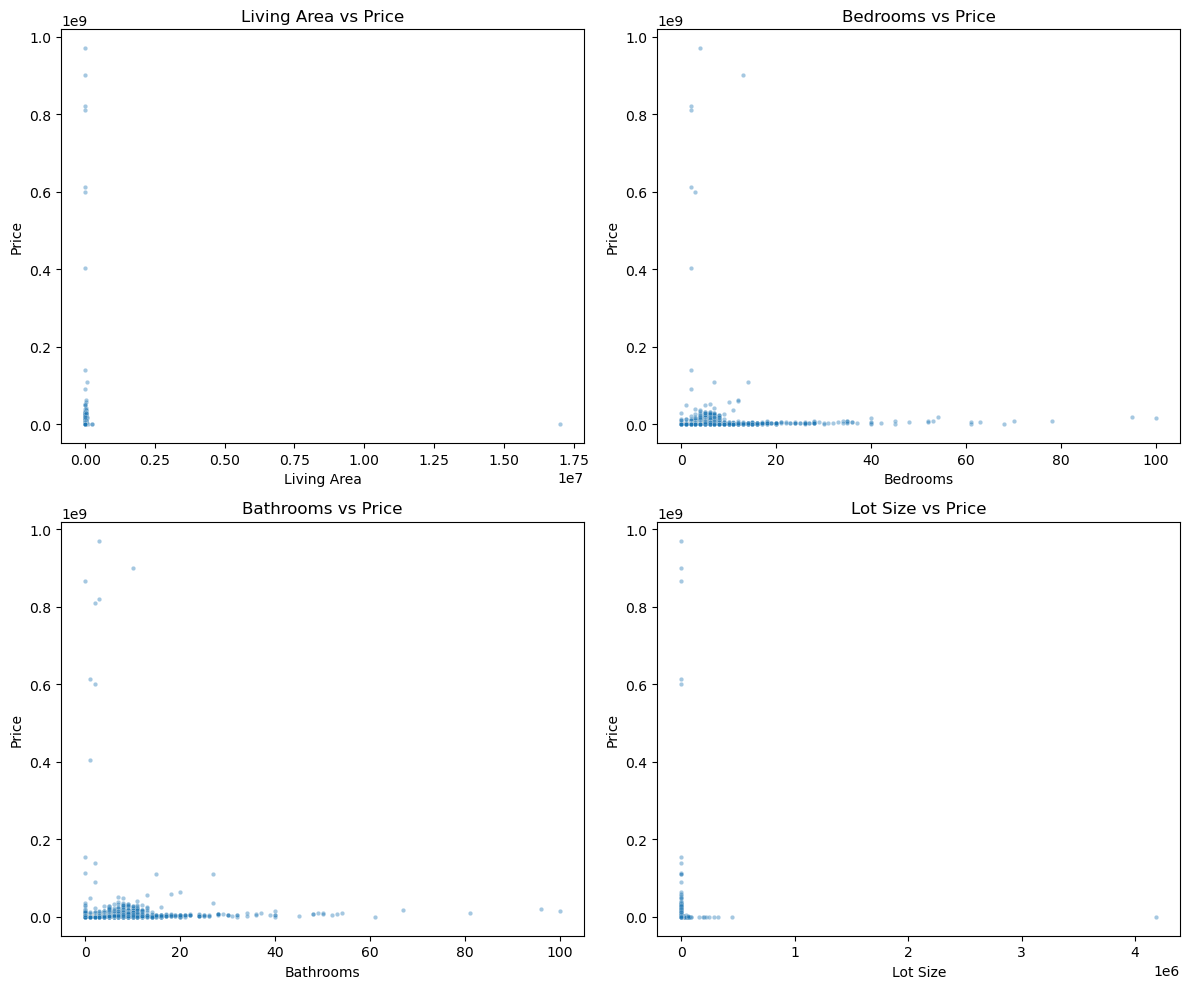

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Try to detect key numeric columns
aliases = {
    'price': ['close_price','closeprice','sold_price','sale_price','final_sales_price','final_price','closing_price'],
    'area': ['living_area','livingarea','sqft','square_feet','square_footage'],
    'beds': ['bedroomstotal','beds','bedrooms'],
    'baths': ['bathroomstotalinteger','baths','bathrooms'],
    'lot': ['lotsizeacres','lot_size_acres','lot_size','lotsize','acres'],
}

cols_lower = {c.lower(): c for c in df.columns}
sel = {}
for k, cands in aliases.items():
    sel[k] = next((cols_lower[c] for c in cands if c in cols_lower), None)

# Build a numeric dataset for EDA
eda_cols = [c for c in sel.values() if c is not None]
num_df = df[eda_cols].copy()

# Coerce to numeric where possible
for c in num_df.columns:
    if not np.issubdtype(num_df[c].dtype, np.number):
        num_df[c] = (
            num_df[c]
            .astype(str)
            .str.replace(',','', regex=False)
            .str.replace('$','', regex=False)
        )
        num_df[c] = pd.to_numeric(num_df[c], errors='coerce')

num_df = num_df.dropna(how='all')

# Scatter plots: price vs key features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plots = [
    ('area', 'Living Area'),
    ('beds', 'Bedrooms'),
    ('baths', 'Bathrooms'),
    ('lot', 'Lot Size'),
]

for ax, (key, label) in zip(axes, plots):
    xcol = sel.get(key)
    ycol = sel.get('price')
    if xcol and ycol and xcol in num_df.columns and ycol in num_df.columns:
        sns.scatterplot(x=num_df[xcol], y=num_df[ycol], ax=ax, s=10, alpha=0.4)
        ax.set_xlabel(label)
        ax.set_ylabel('Price')
        ax.set_title(f'{label} vs Price')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# Pairplot for multicollinearity
sns.pairplot(num_df.dropna(), corner=True, diag_kind='hist', plot_kws={'alpha':0.3, 's':10})
plt.show()

In [ ]:
# Correlation heatmap
corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation heatmap')
plt.show()